# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

This section deals with 2D Conv Model 

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,29))          #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        
        # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        x = len(img_idx) 
        total_frames = x
        y = 100
        z = 100
        
        num_batches = len(folder_list)//batch_size        # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # I was able to find only 2 image sizes(w*h) 160*120 and 360*360, 
                    # So cropping 160*120 images on both left and right side to make it 120*120.
                    height, width , channel = image.shape
                    #print('Width:', width)
                    #print('Height:', height)
                    
                    #if width == 160:
                    #    image_crop = image[0:120, 20:140]
                    #    image = image_crop
                    
                    # Re-sizing both 120*120 (cropped) and 360*360 images into 100*100 image
                    new_image = cv2.resize(image,(y,z))
                    new_image[:,:,1:2] = 0
                    
                    batch_data[folder,idx,:,:,0] = (new_image[:,:,0] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (new_image[:,:,1] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (new_image[:,:,2] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if len(folder_list) > num_batches * batch_size:
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # I was able to find only 2 image sizes(w*h) 160*120 and 360*360, 
                    # So cropping 160*120 images on both left and right side to make it 120*120.
                    height, width , channel = image.shape
                    #print('Width:', width)
                    #print('Height:', height)
                    
                    #if width == 160:
                    #    image_crop = image[0:120, 20:140]
                    #    image = image_crop
                    
                    # Re-sizing both 120*120 (cropped) and 360*360 images into 100*100 image
                    new_image = cv2.resize(image,(y,z))
                    new_image[:,:,1:2] = 0
                    
                    batch_data[folder,idx,:,:,0] = (new_image[:,:,0] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (new_image[:,:,1] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (new_image[:,:,2] - new_image.mean())/new_image.std()   #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here


cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(100,100,3)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) 
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(64, (3, 3), padding='same', input_shape=(100,100,3)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) 
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(128, (3, 3), padding='same', input_shape=(100,100,3)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) 
cnn.add(MaxPooling2D(pool_size=(2,2)))
 

cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(256, activation='relu'))


model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(29, 100, 100,3)))
model.add(GRU(12))
model.add(Dropout(.2)) #added
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
optimiser = optimizers.SGD(lr=0.01);           #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 29, 256)           4878784   
_________________________________________________________________
gru_1 (GRU)                  (None, 12)                9684      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 65        
Total params: 4,888,533
Trainable params: 4,888,085
Non-trainable params: 448
_________________________________________________________________
None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)          # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/valSource path =  ./Project_data/train ; batch size = 20
Epoch 1/10
 ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


32/34 [===========================>..] - ETA: 11s - loss: 1.7523 - categorical_accuracy: 0.2281

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


34/34 [==============================] - 195s 6s/step - loss: 1.7440 - categorical_accuracy: 0.2324 - val_loss: 1.5874 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2019-03-1716_27_37.056102/model-00001-1.74397-0.23235-1.58738-0.23000.h5
Epoch 2/10
34/34 [==============================] - 63s 2s/step - loss: 1.6233 - categorical_accuracy: 0.2485 - val_loss: 1.6183 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model_init_2019-03-1716_27_37.056102/model-00002-1.62331-0.24853-1.61826-0.27000.h5
Epoch 3/10
34/34 [==============================] - 62s 2s/step - loss: 1.5630 - categorical_accuracy: 0.3118 - val_loss: 1.4470 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2019-03-1716_27_37.056102/model-00003-1.56298-0.31176-1.44696-0.38000.h5
Epoch 4/10
34/34 [==============================] - 62s 2s/step - loss: 1.4245 - categorical_accuracy: 0.4103 - val_loss: 1.4231 - val_categorical_accuracy: 0.3900

Epoch 00004

In [12]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


Text(0.5, 1.0, 'Accuracy Curves')

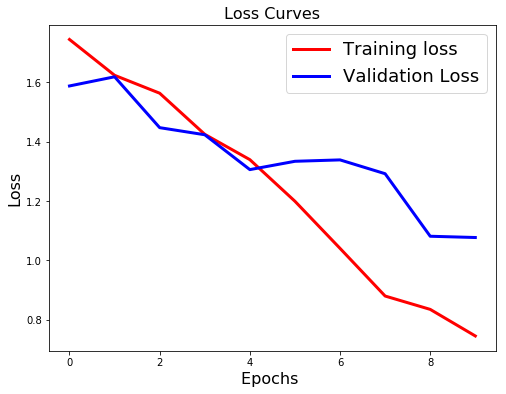

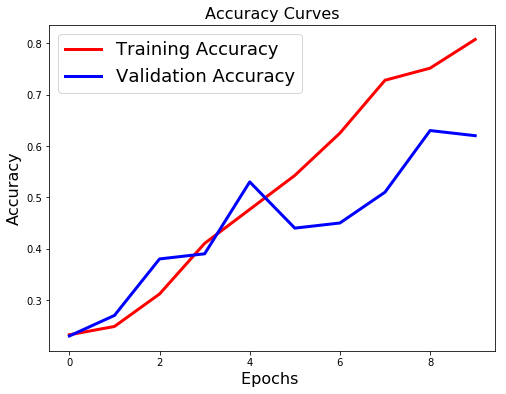

In [13]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)